In [4]:
import pandas as pd
import json
import numpy as np
from os import listdir
from io import StringIO
from Bio import Phylo, AlignIO
from Bio.Alphabet import generic_dna
import re

path="/home/maeperez/scratch/Clams/hyphy2.5/gard_LCB2/"
aln_breakdown='../mauve_alignments/core_ALL_alignments/'
path_out="/home/maeperez/projects/def-bacc/maeperez/Clams/VesicSymb_Evolution/dowstream_analyses_and_data/"
path_to_files='../mauve_alignments/core_ALL_alignments/'


In [5]:

genes=[]
for file in listdir(path):
    if file[-4:]=="json":
        genes+=[str(file.split('.')[0])]
genes=sorted(genes)
print(len(genes))


714


In [6]:
path_to_files='../mauve_alignments/core_ALL_alignments/'
with open(path_to_files+'filelist','r') as f:
    lines=[file[8:-6] for file in f.read().splitlines()]

failed_gard=sorted(set(lines)-set(genes))
failed_gard_idx=[lines.index(gene)+1 for gene in failed_gard]
print(len(failed_gard))
print('\n'.join([' '.join(map(str,item)) for item in list(zip(failed_gard_idx,failed_gard))]))
','.join(map(str,failed_gard_idx))


2
54 LCB_054
608 LCB_608


'54,608'

In [7]:
failed_gard=['LCB_054', 'LCB_608']

['LCB_054',
 'LCB_189',
 'LCB_337',
 'LCB_368',
 'LCB_451',
 'LCB_464',
 'LCB_468',
 'LCB_574',
 'LCB_585',
 'LCB_608']

In [7]:
filenames=[]
with_recombination=[]
for gene in genes:
    remote_file = open(path+gene+'.GARD.json')
    gard_json = json.load(remote_file)
    breakpoints=[0]+[gard_json['input']['number of sites']]
    
    if 'improvements' not in gard_json.keys():
        pass
        
    else: 
        best_AICc=sum([gard_json['improvements'][bp]['deltaAICc'] for bp in gard_json['improvements'].keys()])+gard_json['baselineScore']
        AICc_ratio=float(gard_json['singleTreeAICc'])/best_AICc
        if AICc_ratio>=1:
            with_recombination+=[gene]
            
            ### Find all puttive breakpoints
            breakpoints=[0]+[gard_json['breakpointData'][k]['bps'][0][1] for k in gard_json['breakpointData'].keys()]
#             print(breakpoints)
            
    ### break alignment at all putative breakpoints ###
    alignment = AlignIO.read(path_to_files+gene+'.fasta', "fasta",alphabet=generic_dna)
    start=breakpoints.pop(0)
    sub=0
    while len(breakpoints)>0:
        sub+=1
        end=breakpoints.pop(0)
        new_aln= alignment[:,start:end]

        for record in new_aln:
            record.id = record.id.split('/')[-2].split('_')[0].replace('.gbk','')

        new_aln.sort()
        filename=gene+'_'+str(sub)+'_'+str(start)+'to'+str(end)+'.nex'
        filenames+=filename

        AlignIO.write([new_aln],aln_breakdown+'nex2/'+filename, "nexus")
#         print(filename)

        start=end

print( 'number of genes that failed AICc test ',len(with_recombination),"/",len(genes))  # 65 / 714   #106/716   

number of genes that failed AICc test  65 / 714


In [4]:
# with open(path_out+'core_LCB_with_recomb_AICc.txt','w') as f:
#     f.write('\n'.join(with_recombination))

In [15]:
LCBfrags=[]
nex1=[]
for file in listdir(aln_breakdown+'nex/'):
    if file=='filelist':
        continue
    nex1+=[file]
    fraglen=int(file.split('_')[-1].replace('.nex','').split('to')[1])-int(file.split('_')[-1].replace('.nex','').split('to')[0])
    LCBfrags+=[fraglen]
    if fraglen==9425:
        print(file)

print(len(LCBfrags))
      
sorted(LCBfrags)[::-1][0]

LCB_189_1_0to9425.nex
888


9425

In [17]:
LCBfrags=[]
nex2=[]
for file in listdir(aln_breakdown+'nex2/'):
    if file=='rerun_mb_filelist':
        continue
    nex2+=[file]
    fraglen=int(file.split('_')[-1].replace('.nex','').split('to')[1])-int(file.split('_')[-1].replace('.nex','').split('to')[0])
    LCBfrags+=[fraglen]
    if fraglen==9425:
        print(file)

print(len(LCBfrags))
      
sorted(LCBfrags)[::-1][0]

LCB_189_1_0to9425.nex
791


9425

In [ ]:
### Files that dont have to be rerun because same as previous; should just move 
from shutil import copyfile
print(len([file for file in nex2 if file in nex1]))
unchanged=[file.replace('.nex','.in') for file in nex2 if file in nex1]
# print(unchanged)
for file in unchanged:
    copyfile('/home/maeperez/scratch/Clams/bucky/mrbayes/'+file,'/home/maeperez/scratch/Clams/bucky2/mrbayes/'+file)

In [13]:
### Files that have to be redone should be written in filelist
rerun_mb=[file for file in nex2 if file not in nex1]
print(len(rerun_mb))
with open(aln_breakdown+'nex2/rerun_mb_filelist','w') as fa:
    fa.write('\n'.join(rerun_mb))

195


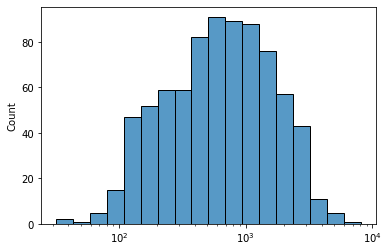

In [26]:
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
importlib.reload(sns)

# importlib.reload(plt)
# Set figure size with matplotlib
# plt.figure(figsize=(10,6))
 
# Create scatter plot
sns.histplot(LCBfrags,log_scale=True)
# sns.histplot(LCBfrags)
